# Remember to save this as a new notebook before you begin solving!! 
# Also remember to open the notebook through a virtual env that works well with keras

### This exercise is meant to teach you how to use embedding layers, and how to create a recommendation system. The data we'll use is the data from the Netflix Prize. This exercise should come after you have some experience with NN (not necessarily extensive experience)

### Author: Philip Tannor

#### Data description: The first line of each 'batch of movies' contains the movie_id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:
CustomerID,Rating,Date
MovieIDs range from 1 to 17770 sequentially. 
CustomerIDs range from 1 to 2649429, with gaps. 
There are 480189 users. 
Ratings are on a five star (integral) scale from 1 to 5. 
Dates have the format YYYY-MM-DD.

#### Note that originally the data was stored with one movie per file. This is a new, easier, format created by a kaggler (DLao @ Hong Kong) with a later touch of Ittai Haran.
Since I don't think that arranging the data teaches very much, I left the basic lines of preprocessing that I did. Feel free to delete it and start over - just make sure to split the data on your own to train and test (randomly). 
If you're more hard-working than I am - used the dates in the original data to split in a more realistic manner (regarding time). Notice there is an apparent leakage - since we create the dictionaries base on all of the data. This is intentional, and also realistic (we can't use these ML techniques for new users or movies).

In [1]:
import keras
import pandas as pd
import numpy as np
from collections import Counter

import os
from sklearn.model_selection import train_test_split

In [2]:
import random

n = 100480507
s = 100000
skip = sorted(random.sample(range(1,n+1),n-s))

df = pd.read_csv("resources/combined_data.csv", skiprows=skip)

print(df.columns)
print(df.shape)

Index(['user_id', 'grade', 'date', 'num'], dtype='object')
(100000, 4)


In [24]:
df = pd.read_csv("resources/combined_data.csv", nrows=500000)
print(df.columns)
print(df.shape)

Index(['user_id', 'grade', 'date', 'num'], dtype='object')
(500000, 4)


In [25]:
#we drop the date since this isn't used for the embedding model
df = df.rename(columns = {'num': 'movie_id', 'grade': 'rating'}).drop('date', axis = 1)[['user_id', 'movie_id', 'rating']]
df.tail()

,user_id,movie_id,rating
499995,178520,148,3
499996,1257939,148,5
499997,1700782,148,2
499998,380354,148,1
499999,753663,148,4


In [26]:
print('Dataset shape: {}'.format(df.shape))

Dataset shape: (500000, 3)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('rating', axis = 1), df.rating, test_size = 0.3, random_state = 77)

In [28]:
#this cell creates dictionaries which help with changing the unique ID's into series of int's. 
#This is neccessary for embedding layers in keras (so use the transformed columns later on), 
#especially if you only use part of the data.

list_unique = list(set(df.user_id))
transforming_user = {v:k for k,v in zip(range(len(list_unique)), list_unique)}
list_unique = list(set(df.movie_id))
transforming_movie = {v:k for k,v in zip(range(len(list_unique)), list_unique)}

X_train['user_id_transformed'] = X_train['user_id'].apply(lambda x: transforming_user[x])
X_train['movie_id_transformed'] = X_train['movie_id'].apply(lambda x: transforming_movie[x])

X_test['user_id_transformed'] = X_test['user_id'].apply(lambda x: transforming_user[x])
X_test['movie_id_transformed'] = X_test['movie_id'].apply(lambda x: transforming_movie[x])

# OK, now go through the instructions - and then you'll be on your own for a while. 

1. Read about embedding layers here: https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12. The explanation isn't detailed enough, but you should try to think of the layer as a change of representation - from a very sparse one-hot vector (which is equivalent), to a dense vector of much lower dimension. In the new representation, each element really means something - and sometimes these elements may be translated into a scale which correlated with some intuitive feature (age, connection holocaust content, spendable income, etc.). 
2. Pay attention that this function which creates the change of representation (the embedding layer) is learned as the network trains. This means that at the beginning - the elements in the new representation won't mean much, but as the learning progresses the representation will be more and more meaningful.
3. Create a neural network in Keras (use functional API - *NOT SEQUENTIAL*. This will become important later on). The NN should have 2 different embedding layers - one which get the user_id as inputs, and one that gets the movie_id as input. I won't tell you the dimension of the 2 new representations - play around with these 2 numbers. Intuitively - try to think how many number you would need to describe a user (same thing for a movie). Notice that 'input_dim' is the size of the vocabulary (and not '1').
4. These embedding layers should be merged, and then flattened. After this, add a few dense layers. If you get the hang of the training and don't want to wait too long, or if you want to compare to my model, read the model in the hidden answers folder using keras.model.load_model. TL;DR - the saved model reaches an MSE of a bit less than 0.72.
5. The output should be a single number - this can be treated as a regression problem, or as an ordinal classification problem. Originally, it was treated as a regression problem by Netflix, so your output should be a floating number between 1 and 5 and you should minimize the MSE.
6. Bonus: treat this as an ordinal classification problem, and use the loss from this paper (squared EMD): https://arxiv.org/abs/1611.05916. This bonus shouldn't be attempted if this is the first time you've dealt with custom losses or ordinal classification. Also, notice there is more work to be done later on in the notebook (which isn't "a bonus")!

In [29]:
list_unique_user_id = list(set(df.user_id))
print(len(list_unique_user_id))

list_unique_movie_id = list(set(df.movie_id))
print(len(list_unique_movie_id))

215008
148


In [44]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, concatenate, Flatten

user_dim = 15
movie_dim = 8

x_user = Input(shape = (1,))
embedding_user = Embedding(input_dim = len(list_unique_user_id), output_dim = user_dim, dtype='float32', input_length=1)(x_user)

x_movie = Input(shape = (1,))
embedding_movie = Embedding(input_dim = len(list_unique_movie_id), output_dim = movie_dim, dtype='float32', input_length=1)(x_movie)

concat = concatenate([embedding_user, embedding_movie], axis = -1)

flatten = Flatten()(concat)
dense1 = Dense(units = (user_dim + movie_dim), activation = 'tanh')(flatten)
dense2 = Dense(units = int((user_dim + movie_dim)), activation = 'tanh')(dense1)
dense3 = Dense(units = int((user_dim + movie_dim)), activation = 'tanh')(dense2)
# dense4 = Dense(units = int((user_dim + movie_dim)), activation = 'tanh')(dense3)
output_layer = Dense(units = 1, activation = 'linear')(dense3)

model = Model(inputs = [x_user, x_movie], outputs = output_layer)

In [45]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = 'mse')
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 15)        3225120     input_19[0][0]                   
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 1, 8)         1184        input_20[0][0]                   
______________________________________________________________________________________

In [46]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [es]

model.fit(x=[X_train['user_id_transformed'], X_train['movie_id_transformed']], y=y_train, 
         validation_data=([X_test['user_id_transformed'], X_test['movie_id_transformed']], y_test),
         epochs=100, verbose=1, batch_size = 1000, callbacks=callbacks_list)

Epoch 1/100
350/350 [==============================] - 19s 54ms/step - loss: 8.9703 - val_loss: 2.4293
Epoch 2/100
350/350 [==============================] - 19s 53ms/step - loss: 1.2649 - val_loss: 1.0557
Epoch 3/100
350/350 [==============================] - 17s 49ms/step - loss: 1.0024 - val_loss: 1.0197
Epoch 4/100
350/350 [==============================] - 18s 50ms/step - loss: 0.9347 - val_loss: 1.0131
Epoch 5/100
350/350 [==============================] - 18s 51ms/step - loss: 0.8422 - val_loss: 1.0302
Epoch 6/100
350/350 [==============================] - 18s 52ms/step - loss: 0.7390 - val_loss: 1.0729
Epoch 7/100
350/350 [==============================] - 19s 55ms/step - loss: 0.6506 - val_loss: 1.1223
Epoch 8/100
350/350 [==============================] - 18s 52ms/step - loss: 0.5854 - val_loss: 1.1617
Epoch 9/100
350/350 [==============================] - 18s 51ms/step - loss: 0.5395 - val_loss: 1.1916
Epoch 00009: early stopping


In [65]:
df.describe()

,user_id,movie_id,rating
count,1.000000e+05,100000.000000,100000.000000
mean,1.323474e+06,9070.212670,3.606480
std,7.647833e+05,5151.669201,1.084709
min,7.900000e+01,3.000000,1.000000
25%,6.636540e+05,4661.000000,3.000000
50%,1.321212e+06,9049.000000,4.000000
75%,1.983551e+06,13651.000000,4.000000
max,2.649426e+06,17770.000000,5.000000


### Great! If you've reached here, you manged to create a neural network which uses embeddings and can predict movie rankings using only very basic information (unique ID's). 
Now we want to turn this into a recommendation system. Write a function which gets one specific user_id as an input, and outputs 10 names of movies with the highest expected ratings. Read the file named movie_titles.csv to connect between the movie id's and the names of the files.

In [26]:
movies_df = pd.read_csv('resources/movie_titles.csv', header = None)#, names = ['movie_id', 'year', 'name'])

movies_dict = {v: k for v, k in zip(movies_df[0], movies_df[2])}
untransforming_movie = {v: k for k, v in transforming_movie.items()}

In [27]:
def recommend_10(user):
    recommend_df = pd.DataFrame(list(set(X_test.movie_id_transformed)), 
                                columns = ['movie_id_transformed'])
    recommend_df['user_id_transformed'] = [transforming_user[user]] * len(recommend_df)
    recommend_df['predictions'] = model.predict([recommend_df['user_id_transformed'], 
                                                 recommend_df['movie_id_transformed']])
    
    top_10 = recommend_df.sort_values('predictions', ascending = False).head(10)
    top_10['movie_id'] = top_10.movie_id_transformed.apply(lambda x: untransforming_movie[x])
    
    return top_10.movie_id.apply(lambda x: movies_dict[x])

In [30]:
recommend_10(2621442)

12    Lord of the Rings: The Return of the King: Ext...
17                                     Immortal Beloved
27                                      Lilo and Stitch
24        Inspector Morse 31: Death Is Now My Neighbour
29                               Something's Gotta Give
2                                             Character
0                                       Dinosaur Planet
28                                              Boycott
4                              The Rise and Fall of ECW
9                                               Fighter
Name: movie_id, dtype: object

### So is the system we built any good? We can check this at least somewhat by checking if the embeddings are good. This is how we'll do it: 
1. Extract the embeddings of the different movies from the network. How, you may ask? I hope you remembered to use the functional api. This will allow you to create a new model - using the trained layers that you already used. Create a new Model where the input is the movie_id, and the output is the movie embedding layer (before the merge).
2. Do not train this model. Only use the .predict of this model, and the output should be the embedding vectors which represent the different movie id's. Notice you may have to reshape the matrix of the predictions for the next steps.
3. Now use sklearn.cluster.KMeans to cluster these vectors. Use k=1000. Make sure to save the cluster number for each movie.
4. Check manually if the clusters make sense (can you find connections between movies in the same cluster?). 
5. Try to visualize the clustering by looking at only some of the clusters as one time. You can use PCA with n_components = 2 to help you visualize (use a different color for each cluster by using 'c = ...' in plt.scatter).

In [136]:
model_embedding = Model(inputs = [x_movie], outputs = [embedding_movie])

movies_for_pred = np.array(X_test['movie_id_transformed'])
vectors = model_embedding.predict(movies_for_pred).reshape(-1,1)
vectors = vectors.reshape(-1,movie_dim)

In [137]:
print(vectors.shape)

(30000, 20)


In [138]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=500)
clusters = clf.fit_predict(vectors)

In [139]:
print(clusters.shape)

(30000,)


In [140]:
clusters_1 = clusters == 1
print(np.sum(clusters_1))

122


In [141]:
clusters_2 = clusters == 2
print(np.sum(clusters_2))

33


In [142]:
clusters_3 = clusters == 3
print(np.sum(clusters_3))

103


In [143]:
from sklearn.decomposition import PCA

In [144]:
clusters_1_2 = clusters_1 + clusters_2 + clusters_3

vectors_chosen = vectors[clusters_1_2]
pca = PCA(n_components = 2)
pcaed_vectored = pca.fit_transform(vectors_chosen)

In [145]:
print(vectors_chosen.shape)

(258, 20)


In [146]:
colors = clusters_1 + 2*clusters_2 + 3*clusters_3
colors = colors[colors != 0]

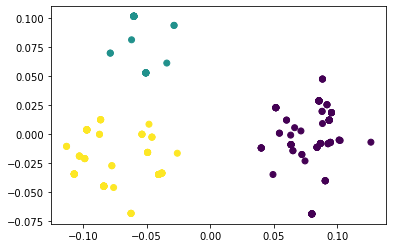

In [147]:
plt.scatter(pcaed_vectored[:,0], pcaed_vectored[:,1], c=colors)
plt.show()

In [134]:
movies_dict[X_test.movie_id.to_numpy()[0]]

'Lara Croft: Tomb Raider: The Cradle of Life'

In [135]:
X_test.shape

(30000, 4)

In [152]:
for movie_id in X_test.movie_id.to_numpy()[clusters == 100]:
    print(movies_dict[movie_id])

Mission: Impossible II
Judge Dredd
Murder By Numbers
The Last American Virgin
Mission: Impossible II
Judge Dredd
Friday
Poirot: Lord Edgware Dies
La Belle Noiseuse
Poirot: Death in the Clouds
Southern Comfort
La Belle Noiseuse
Friday
Mission: Impossible II
Friday
Mission: Impossible II
Murder By Numbers
Murder By Numbers
Whatever It Takes
Mission: Impossible II
Murder By Numbers
Friday
Murder By Numbers
Murder By Numbers
Godzilla vs. Mechagodzilla
Murder By Numbers
Mission: Impossible II
Don Juan De Marco
Just One of the Guys
Friday
Quicksand
Murder By Numbers
Don Juan De Marco
Carnage
Murder By Numbers
The Beastmaster
Murder By Numbers
Judge Dredd
The Beastmaster
Mission: Impossible II
Red Heat
The Girl
Friday
Airport '77 / The Concorde: Airport '79: Double Feature
Mission: Impossible II
Mission: Impossible II
Mission: Impossible II
Mission: Impossible II
Murder By Numbers
Live From Baghdad
Don Juan De Marco
Murder By Numbers
Disorganized Crime
Vampire in Brooklyn
Mission: Impossible 

### Great! Now just one little sophistication. 
Write another function which gives me the top 10 movies while no 2 of them are from the same cluster. This can be used for a more sophisticated type of recommendation system.

This will be more exciting if you go back and reduce the amount of clusters you allow to be not much higher than 10 (and check how the previous system you created will react).

In [156]:
movie_id_transformed_to_cluster = dict(zip(movies_for_pred, clusters))

In [161]:
list_unique = list(set(df.user_id))
transforming_user = {v:k for k,v in zip(range(len(list_unique)), list_unique)}
list_unique = list(set(df.movie_id))
transforming_movie = {v:k for k,v in zip(range(len(list_unique)), list_unique)}

untransforming_movie = {v: k for k, v in transforming_movie.items()}

In [162]:
def recommend_10(user):
    recommend_df = pd.DataFrame(list(set(X_test.movie_id_transformed)), 
                                columns = ['movie_id_transformed'])
    recommend_df['user_id_transformed'] = [transforming_user[user]] * len(recommend_df)
    recommend_df['predictions'] = model.predict([recommend_df['user_id_transformed'], 
                                                 recommend_df['movie_id_transformed']])
    
    top_10 = recommend_df.sort_values('predictions', ascending = False).head(10)
    top_10['movie_id'] = top_10.movie_id_transformed.apply(lambda x: untransforming_movie[x])
    
    return top_10.movie_id.apply(lambda x: movies_dict[x])

In [163]:
def recommend_10_from_different_clusters(user):
    recommend_df = pd.DataFrame(list(set(X_test.movie_id_transformed)), 
                                columns = ['movie_id_transformed'])
    recommend_df['user_id_transformed'] = [transforming_user[user]] * len(recommend_df)
    
    recommend_df['predictions'] = model.predict([recommend_df['user_id_transformed'], 
                                                 recommend_df['movie_id_transformed']])
    
    recommend_df['cluster'] = recommend_df.movie_id_transformed.apply(lambda x: 
                                                                      movie_id_transformed_to_cluster[x])

    top_10 = recommend_df.sort_values('predictions', 
                                      ascending = False).groupby('cluster').head(1).head(10)
    
    top_10['movie_id'] = top_10.movie_id_transformed.apply(lambda x: untransforming_movie[x])
    
    return top_10.movie_id.apply(lambda x: movies_dict[x])

In [164]:
recommend_10_from_different_clusters(2621442)

2331    Lord of the Rings: The Two Towers: Extended Ed...
4775            The Shawshank Redemption: Special Edition
4911    Lord of the Rings: The Return of the King: Ext...
4031                                        The Godfather
4481                                            Toy Story
3311                              Raiders of the Lost Ark
63                             Chappelle's Show: Season 1
4693                               The Sopranos: Season 2
4208                                The X-Files: Season 1
2085                                 Millennium: Season 1
Name: movie_id, dtype: object

# These cells should be used for telling yourself when your code finishes running

In [9]:
import datetime
from MMMUtils import *

In [10]:
beep()

body = 'Yo Phil, my man - your code (embedding layer exercise) finished running at: ' + str(datetime.datetime.now()) \
    + '\n\n\nThis was an automated email'
send_email('ptannor@gmail.com', body = body)